In [80]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [81]:
data = "r01"

image_path         = rf"D:\3d-reconstruction\MoGe\output\{data}\image.jpg"
mask_path          = rf"D:\3d-reconstruction\MoGe\output\{data}\r01_mask.png"

faces_path         = rf"D:\3d-reconstruction\MoGe\output\{data}\faces.npy"
vertices_path      = rf"D:\3d-reconstruction\MoGe\output\{data}\vertices.npy"
vertex_colors_path = rf"D:\3d-reconstruction\MoGe\output\{data}\vertex_colors.npy"
uv_path            = rf"D:\3d-reconstruction\MoGe\output\{data}\vertex_uvs.npy"

In [82]:
image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
height, width = image.shape[:2]
image.shape

(400, 711, 3)

In [83]:
faces         = np.load(faces_path)
vertices      = np.load(vertices_path)
vertex_colors = np.load(vertex_colors_path)
vertex_uvs       = np.load(uv_path)

print(faces.shape)
print(vertices.shape)
print(vertex_colors.shape)
print(vertex_uvs.shape)

(549976, 3)
(284400, 3)
(284400, 3)
(284400, 2)


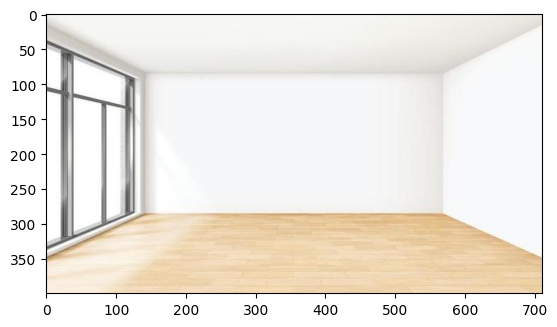

In [84]:
vertex_colors_img = vertex_colors.reshape(400,711,3)
plt.imshow(vertex_colors_img)

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


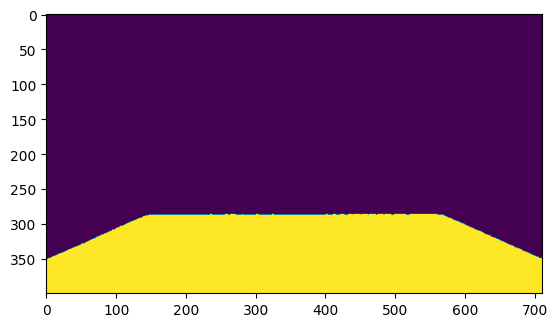

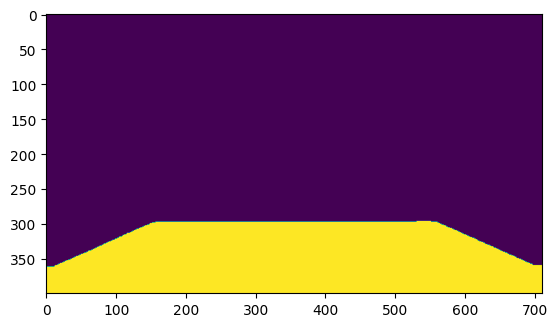

(284400, 1)


array([     0,      1,      2, ..., 256680, 256681, 256682])

In [85]:
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print(mask) # 0/255

mask[mask==255] = 1
print(mask)

plt.imshow(mask)
plt.show()

# Erode mask to help remove potential outliers at the border of the plane
# Define a structuring element (kernel) for erosion
kernel = np.ones((20, 20), dtype=np.uint8)  # 3x3 square kernel
# Apply erosion
eroded_mask = cv2.erode(mask, kernel, iterations=1)
plt.imshow(eroded_mask)
plt.show()

mask = eroded_mask


mask = mask.reshape(-1,1)
print(mask.shape)

idx_to_remove = np.where(mask==0)[0]
idx_to_remove

In [86]:
# Step 1: Create a mask for vertices to keep
mask = np.ones(len(vertices), dtype=bool)
mask[idx_to_remove] = False

# Step 2: Filter out faces referencing deleted vertices
valid_faces_mask = ~np.any(np.isin(faces, idx_to_remove), axis=1)
filtered_faces = faces[valid_faces_mask]

# Step 3: Create a mapping for reindexing the vertices
new_vertex_indices = np.cumsum(mask) - 1  # Map old indices to new ones
filtered_faces = new_vertex_indices[filtered_faces]

# Step 4: Filter the vertices
filtered_vertices      = vertices[mask]
filtered_vertex_colors = vertex_colors[mask]
filtered_vertex_uvs    = vertex_uvs[mask]

# Result
print("Filtered Vertices:")
print(filtered_vertices.shape)
print("Filtered filtered_vertex_colors:")
print(filtered_vertex_colors.shape)
print("Filtered Vertex UV:")
print(filtered_vertex_uvs.shape)
print("Filtered Faces:")
print(filtered_faces.shape)


Filtered Vertices:
(62217, 3)
Filtered filtered_vertex_colors:
(62217, 3)
Filtered Vertex UV:
(62217, 2)
Filtered Faces:
(122871, 3)


In [87]:
# import trimesh
# import trimesh.visual

# trimesh.Trimesh(
#     vertices=filtered_vertices, 
#     faces=filtered_faces, 
#     visual = trimesh.visual.texture.TextureVisuals(
#         uv=filtered_vertex_uvs, 
#         material=trimesh.visual.material.PBRMaterial(
#             baseColorTexture=Image.fromarray(image),
#             metallicFactor=0.5,
#             roughnessFactor=1.0
#         )
#     ),
#     process=False
# ).export(rf"D:\3d-reconstruction\MoGe\output\{data}\masked_mesh.glb")

# trimesh.Trimesh(
#     vertices=filtered_vertices, 
#     faces=filtered_faces, 
#     vertex_colors=filtered_vertex_colors,
#     process=False
# ).export(rf"D:\3d-reconstruction\MoGe\output\{data}\masked_mesh.ply")

In [88]:
import numpy as np

def compute_plane_properties(vertices, faces):
    """
    Compute the position (centroid) and normal vector of a plane defined by multiple faces.
    
    Parameters:
    - vertices: (N, 3) array of vertex positions
    - faces: (M, 3) array of indices of vertices forming each triangular face
    
    Returns:
    - centroid: (3,) array representing the center point of the plane
    - normal: (3,) unit vector representing the normal of the plane
    """
    # Step 1: Compute centroid (average of all vertices in the faces)
    unique_vertex_indices = np.unique(faces.flatten())  # Get unique vertex indices used in the faces
    plane_vertices = vertices[unique_vertex_indices]
    centroid = np.mean(plane_vertices, axis=0)
    
    # Step 2: Compute face normals
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]

    # Compute two edges
    edge1 = v1 - v0
    edge2 = v2 - v0

    # Compute cross product (face normal)
    face_normals = np.cross(edge1, edge2)
    
    # Normalize each face normal
    norms = np.linalg.norm(face_normals, axis=1, keepdims=True)
    face_normals = face_normals / norms  # Avoid division by zero for degenerate triangles
    
    # Step 3: Compute average normal
    average_normal = np.mean(face_normals, axis=0)
    normal = average_normal / np.linalg.norm(average_normal)  # Normalize to unit vector

    return centroid, normal

centroid, normal = compute_plane_properties(filtered_vertices, filtered_faces)

print("Plane Centroid (Position):")
print(centroid)
print("Plane Normal Vector (Rotation):")
print(normal)


Plane Centroid (Position):
[ 0.0035254  -0.34078079 -1.18198281]
Plane Normal Vector (Rotation):
[8.22759779e-04 9.99902071e-01 1.39703545e-02]


In [89]:
# Blender
# [ 0.00246041 , -1.2347566, -0.3401814   ]